# HDA Project 21/22

Authors:
 - Michele Maria Crudele
 - Filippo Ziliotto

This is the code implementede for the HDA course project. 

*All the notebook was run on Colab. The cells do not display the output have still been previously run 

# Libraries

In [1]:
import keras
from matplotlib.transforms import Affine2D
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import RepeatedKFold
import statistics
import pandas as pd
import seaborn as sns
import os
import cv2
from IPython.display import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense, Conv2D,TimeDistributed,Dropout,Layer,Normalization
from keras.layers import MaxPooling2D, Flatten, BatchNormalization,Concatenate,GlobalAveragePooling2D
from keras.layers import SimpleRNN, LSTM
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold,StratifiedKFold, LeaveOneOut,LeaveOneGroupOut
from keras import Input, Model
from scipy import stats, ndimage, misc
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.metrics import classification_report
import random
from keras import backend as K
%config InlineBackend.figure_format = 'retina'

# Functions

In [2]:
def read_experiment_1_17(directory="experiment-i/"):
    li = []

    for root, subdirectories, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',
                               keep_default_na=False,header=None, skiprows=3)
                data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                data = data.iloc[:-3,:]
                data['posture'] = int(str(file)[:-4])
                data['subject'] = str(root[-2:])
                li.append(data)
            else:
                continue
        
    frames = pd.concat(li, axis=0, ignore_index=True)
    return frames

def read_experiment_1_3(directory="experiment-i/"):

    li = []
    for root, subdirectories, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                if file == '1.txt' or file == '8.txt' or file == '9.txt' or file == '10.txt' or file == '11.txt' or file == '12.txt' or file == '15.txt' or file == '16.txt' or file == '17.txt':
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(1)
                    data['subject'] = str(root[-2:])
                    li.append(data)
                if file == '3.txt' or file == '6.txt' or file == '7.txt' or file == '14.txt':
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(2)
                    data['subject'] = str(root[-2:])
                    li.append(data)
                if file == '2.txt' or file == '4.txt' or file == '5.txt' or file == '13.txt':          
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(3)
                    data['subject'] = str(root[-2:])
                    li.append(data)
            else:
                continue
        
    frames = pd.concat(li, axis=0, ignore_index=True)
    return frames

def preprocess(dataframe, test_size):
    
    x = frames.iloc[:,:-2].values.reshape(len(frames),64,32,1)
    x = ndimage.median_filter(x, 3) 
    norm = lambda s: s/1000            #1000 is the maximum value of the pressure on the sensors
    x = np.array([norm(xx) for xx in x])

    y_pos = frames.iloc[:,-2].values
    y_pos = pd.get_dummies(frames['posture']).values

    y_sub = frames.iloc[:,-1].values
    y_sub = pd.get_dummies(frames['subject']).values
    
    X_train,X_test,y_train_pos,y_test_pos,y_train_sub,y_test_sub = train_test_split(x,
                                                                                    y_pos,
                                                                                    y_sub,
                                                                                    test_size = test_size,
                                                                                    shuffle=True)
    print('X train',X_train.shape)
    print('X test',X_test.shape)
    print('Y train position',y_train_pos.shape)
    print('Y train subject',y_train_sub.shape)
    print('Y test position',y_test_pos.shape)
    print('Y test subject',y_test_sub.shape)
    
    return X_train, X_test, y_train_pos, y_train_sub, y_test_pos, y_test_sub

def rot90_on_probability(image, probability= 0.5):
    if random.random() < probability:
        return tf.image.rot90(image,k=2)
    return image

def rot_on_probability(image, probability = 0.2):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_rotation(image,30, channel_axis=2)
    return image

def horiz_on_probability(image, probability = 0.2, shift = 0.1):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_shift(image,wrg=shift,hrg=0.,fill_mode='nearest', channel_axis=2)
    return image

def vertic_on_probability(image, probability = 0.2, shift = 0.1):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_shift(image,wrg=0.,hrg=shift,fill_mode='nearest', channel_axis=2)
    return image

def data_augmentation(X_train, plot=True):
    
    from tensorflow.python.ops.numpy_ops import np_config #non so perchè ma servono quest due righe
    np_config.enable_numpy_behavior() #non so perchè ma servono quest due righe
    X_train_aug = np.empty([len(X_train),64,32,1], dtype='float32')
    
    for i in tqdm(range(X_train_aug.shape[0])):
        image = X_train[i]
        image = tf.convert_to_tensor(image, np.float32)
        image = rot90_on_probability(image)
        image = rot_on_probability(image)
        image = horiz_on_probability(image)
        image = vertic_on_probability(image)
        X_train_aug[i] = image
        
    if X_train_aug.shape == X_train.shape:
        print('Data Augmentation Done!')
        
        if plot:
            plt.figure(figsize=(20,20)) 
            for i in range(10):
                seed = np.random.randint(0,1000)
                plt.subplot(5,5,i+1) 
                plt.imshow(X_train_aug[seed])
                plt.axis('off')
            plt.show()
    else:
        print('Error!')        
        
    return X_train_aug

def nn_model(n_dense=3, n_neurons=512, n_pos=3, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    x = tf.keras.layers.Layer()(input)

    #flatten block
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dense(50, activation='leaky_relu')(x)
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer

def cnn_model(n_conv=2, n_channels=32, n_dense=3, n_neurons=512, n_pos=3, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    x = tf.keras.layers.Layer()(input)
    
    #encoder block
    for i in range(n_conv):
        x = Conv2D(n_channels*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}a'.format(i+1))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(name='MaxPool-{}'.format(i))(x)
        n2 = n_channels*(i+1) 
        
    for i in range(2):
        x = Conv2D(n2*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}b'.format(i+1))(x)

    #flatten block
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer


def cnn_rnn_model(n_conv=2, n_channels=32, n_dense=3, n_neurons=512, n_pos=3, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    x = tf.keras.layers.Layer()(input)
    #encoder block
    for i in range(n_conv):
        x = Conv2D(n_channels*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}a'.format(i+1))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(name='MaxPool-{}'.format(i))(x)
        n2 = n_channels*(i+1) 
        
    for i in range(2):
        x = Conv2D(n2*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}b'.format(i+1))(x)
        
    #flatten block
    x = tf.keras.layers.Reshape((x.shape[1], x.shape[3]*x.shape[2]))(x)
    x = SimpleRNN(128, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(64, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(32, return_sequences=False, activation='relu')(x)
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer

def cnn_lstm_model(n_conv=2, n_channels=32, n_dense=3, n_neurons=512, n_pos=17, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    x = tf.keras.layers.Layer()(input)
    #encoder block
    for i in range(n_conv):
        x = Conv2D(n_channels*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}a'.format(i+1))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(name='MaxPool-{}'.format(i))(x)
        n2 = n_channels*(i+1) 
        
    for i in range(1):
        x = Conv2D(n2*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}b'.format(i+1))(x)
        
    #flatten block
    x = tf.keras.layers.Reshape((x.shape[1], x.shape[3]*x.shape[2]))(x)
    x = LSTM(40, return_sequences=True)(x)
    x = LSTM(32, return_sequences=True)(x)
    x = LSTM(32, return_sequences=False)(x)
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer


def train_model(model, X_train, y_train_sub, y_train_pos,lambda_=0.5, verbose=1, validation_split=0.2, batch_size=100,
                n_epochs=10, plot=True, name_model='3_positions.h5'):
    
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              loss_weights = [lambda_,1-lambda_],
              optimizer='adam',
              metrics=['accuracy'])
    
    monitor_ = 'loss' #monitoring validation accuracy of the subjects

    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,monitor=monitor_),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_,factor=0.5,patience=2, min_lr=0.0001)
    ]
    
    try: history = model.fit(X_train,
                    [y_train_sub,y_train_pos],
                    shuffle=True,
                    epochs=n_epochs, 
                    batch_size=batch_size,
                    validation_split = validation_split, #validate on the augmented data
                    callbacks=my_callbacks,
                    verbose=verbose)

    except KeyboardInterrupt: #stopping training saves the model
        model.save(name_model)
        print('\n ---------------------')
        print('Output saved to: {}'.format(name_model))
        print('---------------------')
        
    model.save(name_model)
    
    if plot:
        plt.plot(history.history['{}_accuracy'.format(sub_layer)])
        plt.plot(history.history['{}_accuracy'.format(pos_layer)])
        plt.plot(history.history['val_{}_accuracy'.format(sub_layer)])
        plt.plot(history.history['val_{}_accuracy'.format(pos_layer)])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend([ 'Train Subject Accuracy','Train Position Accuracy','Val Position Accuracy','Val Subject Accuracy'],
           loc='lower right')
        plt.show()
        
    return model

def test_model(X_test, y_test_sub, y_test_pos, plot=True, classification_rep=True):
    
    sub_pred, pos_pred = model.predict(X_test)
    true_sub, true_pos = y_test_sub.argmax(-1), y_test_pos.argmax(-1)
    sub_pred = sub_pred.argmax(-1)
    pos_pred = pos_pred.argmax(-1)
    
    acc_pos = round(np.sum(true_pos == pos_pred)*100/pos_pred.size,2)
    acc_sub = round(np.sum(true_sub == sub_pred)*100/sub_pred.size,2)


    print('Position Test accuracy:',acc_pos,'%')
    print('Subject Test accuracy:',acc_sub,'%')
    print('---------------------')
    print('---------------------')
    
    if classification_rep:
        print('Posture Classification report')
        print(classification_report(true_pos, pos_pred))

        print('Subject Classification report')
        print(classification_report(true_sub, sub_pred))
    
    matrix_sub = confusion_matrix(true_sub, sub_pred)
    matrix_pos = confusion_matrix(true_pos, pos_pred)
    
    if plot:
        df = pd.DataFrame(matrix_pos)
        n = matrix_pos.shape[0]
        if n==3:
            df = df.rename(columns={0:'Supine',1:'Right',2:'Left'})
        else: 
            df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
            df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

        #normalization
        row_sums = matrix_sub.sum(axis=1)
        matrix_sub_norm = matrix_sub / row_sums[:, np.newaxis]
        row_sums = matrix_pos.sum(axis=1)
        matrix_pos_norm = matrix_pos / row_sums[:, np.newaxis]

        label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

        sns.heatmap(matrix_pos_norm, annot=matrix_pos,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
        
        if n==3:
            ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([3],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([3],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)
        else:
            ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)
            

        sns.heatmap(matrix_sub_norm, annot=matrix_sub,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
        ax2.hlines([0],*plt.xlim(), color='black',lw=2)
        ax2.vlines([13],*plt.xlim(), color='black',lw=2)
        ax2.hlines([13],*plt.xlim(), color='black',lw=2)
        ax2.vlines([0],*plt.xlim(), color='black',lw=2)

        plt.show()
        
    return acc_pos, acc_sub, matrix_pos, matrix_sub

# Preprocessing

In [3]:
frames = pd.read_csv('Experiment1_17pos.csv',  header=0)
frames = frames.drop(range(7939, 7951),axis=0).reset_index(drop=True)
frames = frames.drop([6767, 10147],axis=0).reset_index(drop=True)

In [4]:
x = frames.iloc[:,:-2].values.reshape(len(frames),64,32,1)
x = ndimage.median_filter(x, 3) 
norm = lambda s: s/1000            #1000 is the maximum value of the pressure on the sensors
x = np.array([norm(xx) for xx in x])
x_aug = data_augmentation(x, plot=False)

y_pos = frames.iloc[:,-2].values
y_pos = pd.get_dummies(frames['posture']).values

y_sub = frames.iloc[:,-1].values
y_sub = pd.get_dummies(frames['subject']).values

100%|██████████| 18684/18684 [00:29<00:00, 630.10it/s]

Data Augmentation Done!


# Our Model

In [5]:
def inception_block(input_img, n,i):
    layer_0 = Conv2D(n, (1,1), padding='same', activation='relu', name='Conv0-{}'.format(i))(input_img)
    
    layer_1 = Conv2D(n, (3,3), padding='same', activation='relu', name='Conv1-{}'.format(i))(input_img)
    layer_1 = Conv2D(n, (3,3), padding='same', activation='relu', name='Conv1a-{}'.format(i))(layer_1)

    layer_2 = Conv2D(n, (1,1), padding='same', activation='relu', name='Conv2-{}'.format(i))(input_img)
    layer_2 = Conv2D(n, (5,5), padding='same', activation='relu', name='Conv2a-{}'.format(i))(layer_2)

    layer_3 = MaxPooling2D((3,3), strides=(1,1), padding='same', name='Conv3-{}'.format(i))(input_img)
    layer_3 = Conv2D(n, (1,1), padding='same', activation='relu', name='Conv3a-{}'.format(i))(layer_3)

    mid_1 = tf.keras.layers.concatenate([layer_0,layer_1, layer_2, layer_3], axis = 3)
    return mid_1

In [7]:
def model_ours(n_inception=32, n_dense=32, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')

    low = inception_block(input,n_inception,'Low') 
    low_ = MaxPooling2D((2,2), strides=2, padding='same',name='MaxPool-Low')(low)
    low = Flatten(name='Flatten-Low')(low)
    low = Dense(n_dense, activation='relu', name='Dense-1-Low')(low)
    low = Dense(n_dense, activation='relu', name='Dense-2-Low')(low)
    low = Dense(n_dense, activation='relu', name='Dense-3-Low')(low)
    low = Dropout(0.1, name='Dropout-Low')(low)
    low_pos = Dense(17, activation='relu', name='Output-Low')(low)

    mid = inception_block(low_,n_inception*2,'Mid')
    mid_ = MaxPooling2D((2,2), strides=2, padding='same', name='MaxPool-Mid')(mid)
    mid = Flatten(name='Flatten-Mid')(mid)
    mid = Dense(n_dense, activation='relu', name='Dense-1-Mid')(mid)
    mid = Dense(n_dense, activation='relu', name='Dense-2-Mid')(mid)
    mid = Dense(n_dense, activation='relu', name='Dense-3-Mid')(mid)
    mid = Dropout(0.1, name='Dropout-Mid')(mid)
    mid_pos = Dense(17, activation='relu', name='Output-Mid')(mid)

    high = inception_block(mid_,n_inception*4,'High')
    high_= MaxPooling2D((2,2), strides=2, padding='same', name='MaxPool-High')(high)
    high = Flatten(name='Flatten-High')(high)
    high = Dense(n_dense, activation='relu', name='Dense-1-High')(high)
    high = Dense(n_dense, activation='relu', name='Dense-2-High')(high)
    high = Dense(n_dense, activation='relu', name='Dense-3-High')(high)
    sub = Dense(13, activation='softmax', name='Output-Subject')(high)
    high = Dropout(0.1, name='Dropout-High')(high)
    high_pos = Dense(17, activation='relu', name='Output-High')(high)
    
    pos = tf.keras.layers.Add(name='Add-Feature')([low_pos,mid_pos,high_pos])
    pos = tf.keras.layers.Activation('softmax', name='Softmax-Output')(pos)      
    
    model = Model(inputs=input, outputs=[sub, pos], name='HDA')
    if summary:
        model.summary()
    
    return model

In [ ]:
model = model_ours(n_inception=32, n_dense=64, summary=True)  

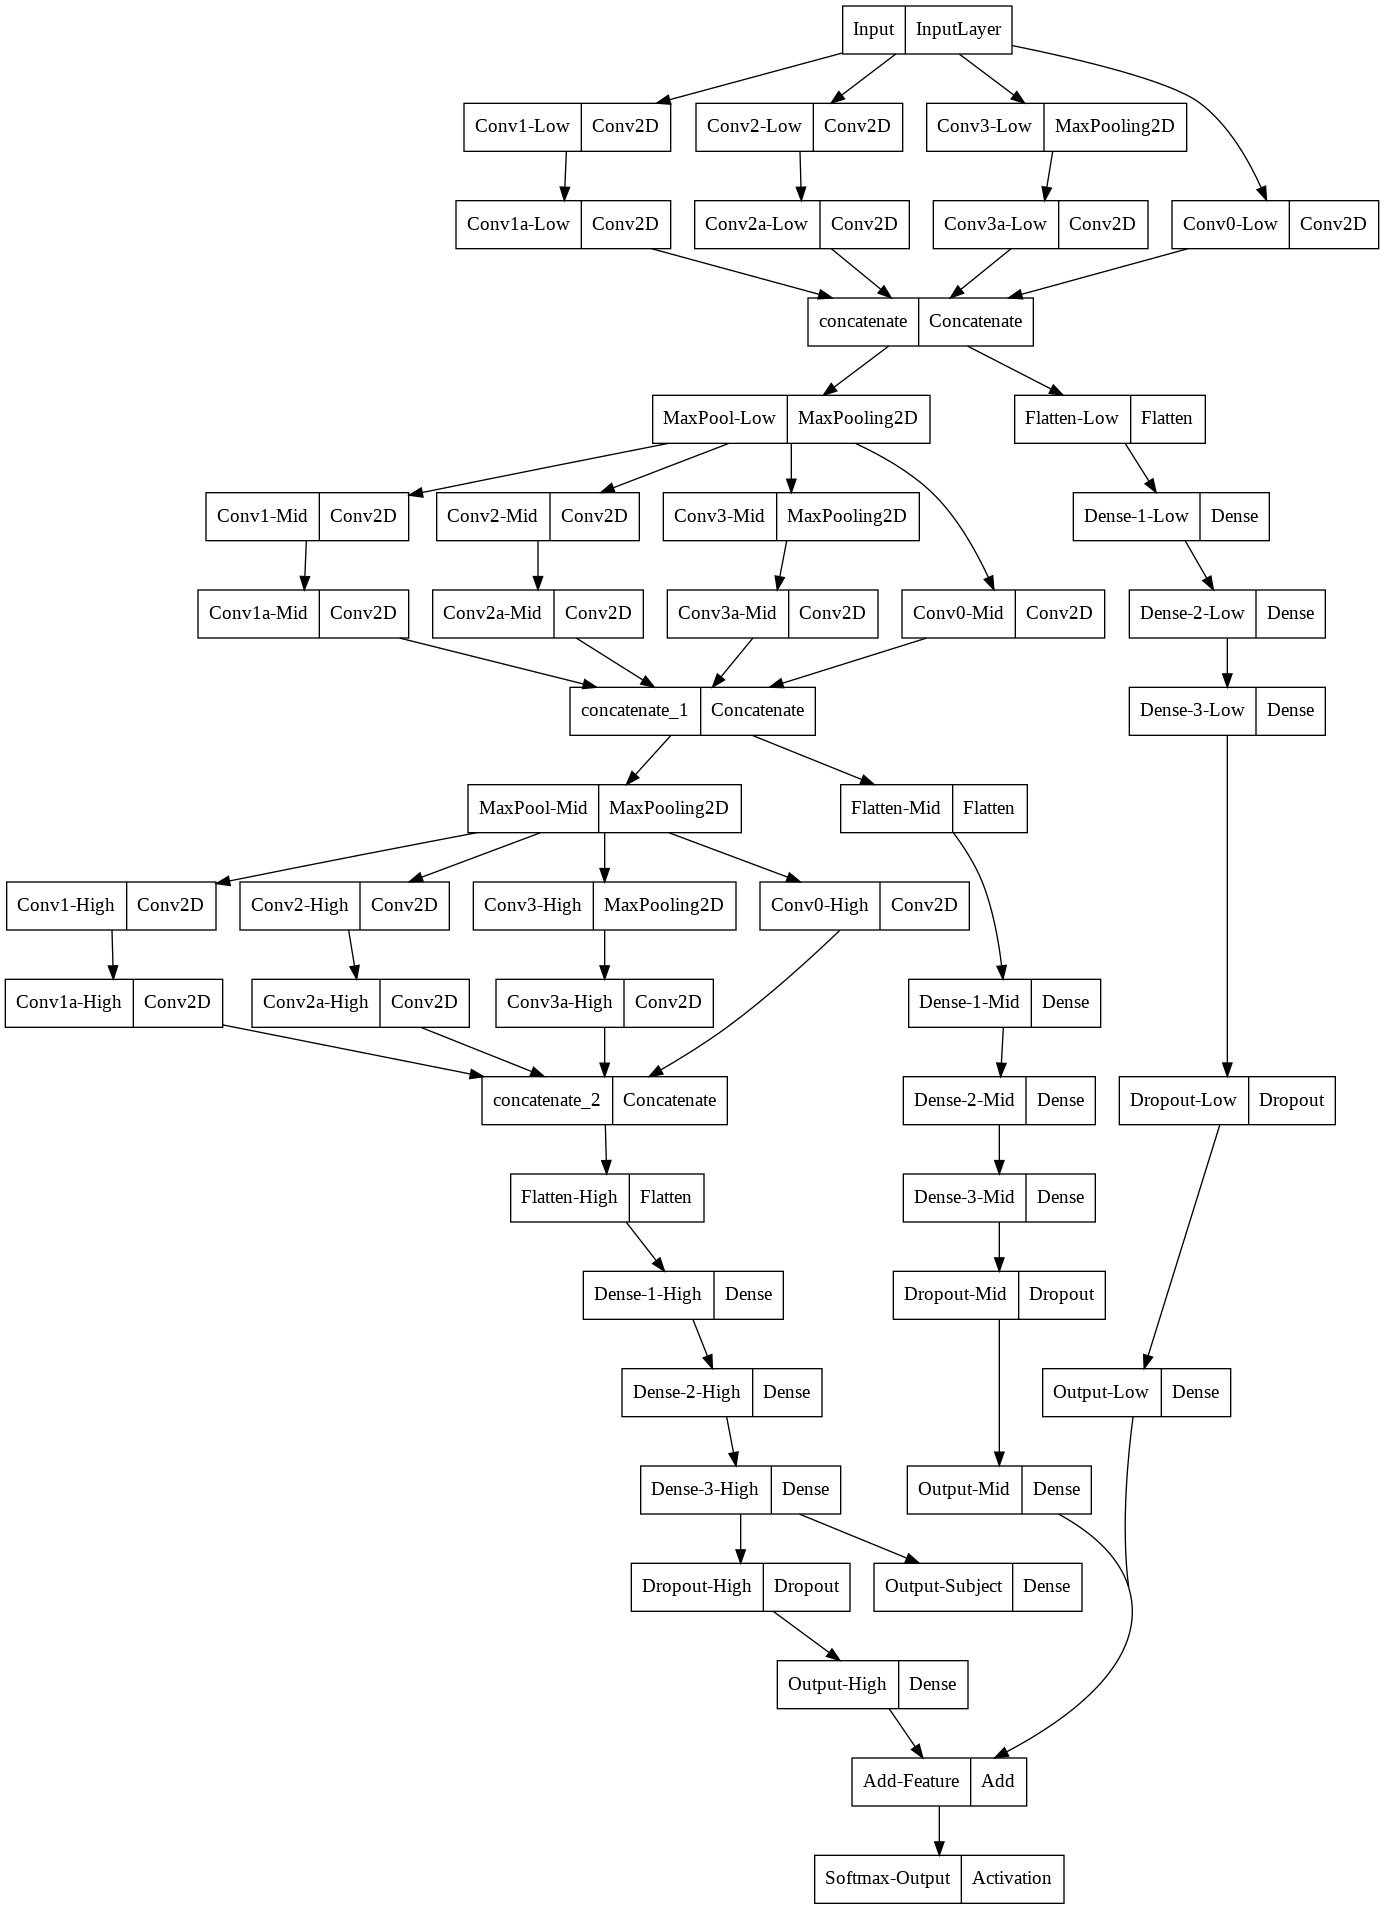

In [11]:
plot_model(model)

# K-Fold validation

Every KFold has been repeated two times, just to have a more accurate results on the variance of the results.

### CNN + RNN


In [ ]:
%%time
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

print('-----------------')
print('KFold Initialization.')
print('-----------------')

#cv = KFold(n_splits=fold, shuffle=True, random_state=123)
cv = RepeatedKFold(n_splits=fold, n_repeats=2,random_state=36851234)
for train, test in cv.split(x):

    X_train, X_test = tf.gather(x_aug, indices=train), tf.gather(x, indices=test) #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]
    y_train_sub, y_test_sub = y_sub[train], y_sub[test]
    
    if k==1: 
        summary=True
    else: summary=False
        
    model, pos_layer, sub_layer = cnn_rnn_model(n_conv=2, n_channels=16, n_dense=3, n_neurons=256, n_pos=17, summary=summary)

    model = train_model(model, X_train, y_train_sub, y_train_pos,
                        plot=False, n_epochs=30, verbose=0, lambda_=0.5, name_model='cnn_rnn.h5')

    acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(X_test,y_test_sub, y_test_pos, 
                                                          plot=False, classification_rep=False)

    matrix_sub_ += matrix_sub
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    kfold_acc_sub.append(acc_sub)

    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    
    tf.keras.backend.clear_session()
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')
print('Average Kfold Subject Accuracy:',round(np.mean(kfold_acc_sub),2),'%')
print('Standard deviation Subject:',round(statistics.pstdev(kfold_acc_sub),2),'%')

-----------------
KFold Initialization.
-----------------
Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 layer (Layer)                  (None, 64, 32, 1)    0           ['Input[0][0]']                  
                                                                                                  
 Conv-1a (Conv2D)               (None, 62, 30, 16)   160         ['layer[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 62, 30, 16)  64          ['Conv-1a[0][0]']                
 alization)                           

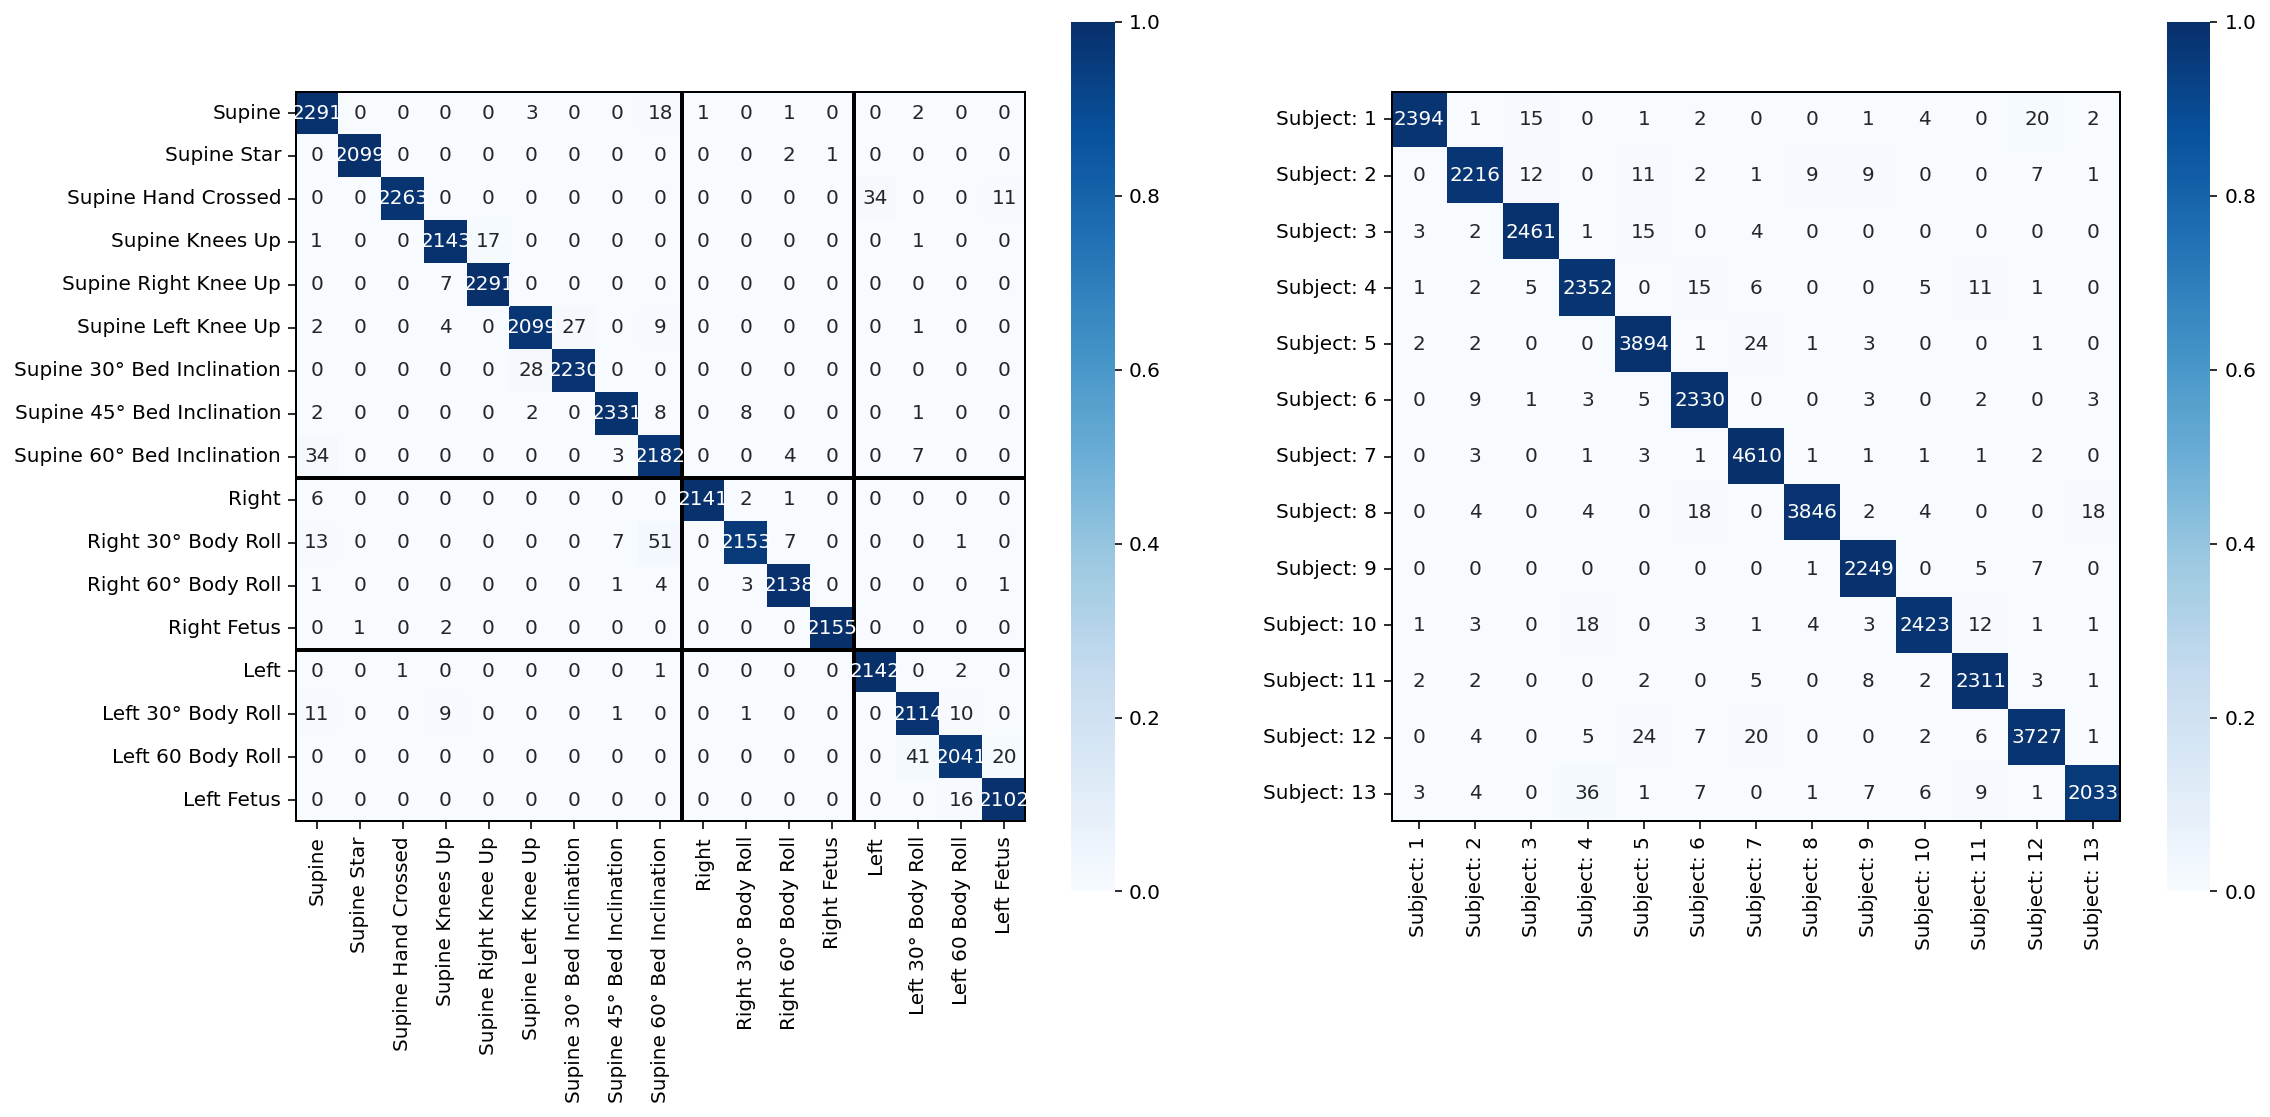

In [ ]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

### CNN + LSTM

In [ ]:
%%time
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

print('-----------------')
print('KFold Initialization.')
print('-----------------')
#cv = KFold(n_splits=fold, shuffle=True, random_state=123)
cv = RepeatedKFold(n_splits=fold, n_repeats=2,random_state=36851234)
for train, test in cv.split(x):

    X_train, X_test = tf.gather(x_aug, indices=train), tf.gather(x, indices=test) #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]
    y_train_sub, y_test_sub = y_sub[train], y_sub[test]
    
    if k==1: 
        summary=True
    else: summary=False
        
    model, pos_layer, sub_layer = cnn_lstm_model(n_conv=2, n_channels=32, n_dense=2, n_neurons=64, n_pos=17, summary=summary)

    model = train_model(model, X_train, y_train_sub, y_train_pos,
                        plot=False, n_epochs=30, verbose=0, lambda_=0.5, name_model='cnn_lstm.h5')

    acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(X_test,y_test_sub, y_test_pos, 
                                                          plot=False, classification_rep=False)

    matrix_sub_ += matrix_sub
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    kfold_acc_sub.append(acc_sub)
    
    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    
    tf.keras.backend.clear_session()
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')
print('Average Kfold Subject Accuracy:',round(np.mean(kfold_acc_sub),2),'%')
print('Standard deviation Subject:',round(statistics.pstdev(kfold_acc_sub),2),'%')

-----------------
KFold Initialization.
-----------------
Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 layer (Layer)                  (None, 64, 32, 1)    0           ['Input[0][0]']                  
                                                                                                  
 Conv-1a (Conv2D)               (None, 62, 30, 32)   320         ['layer[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 62, 30, 32)  128         ['Conv-1a[0][0]']                
 alization)                           

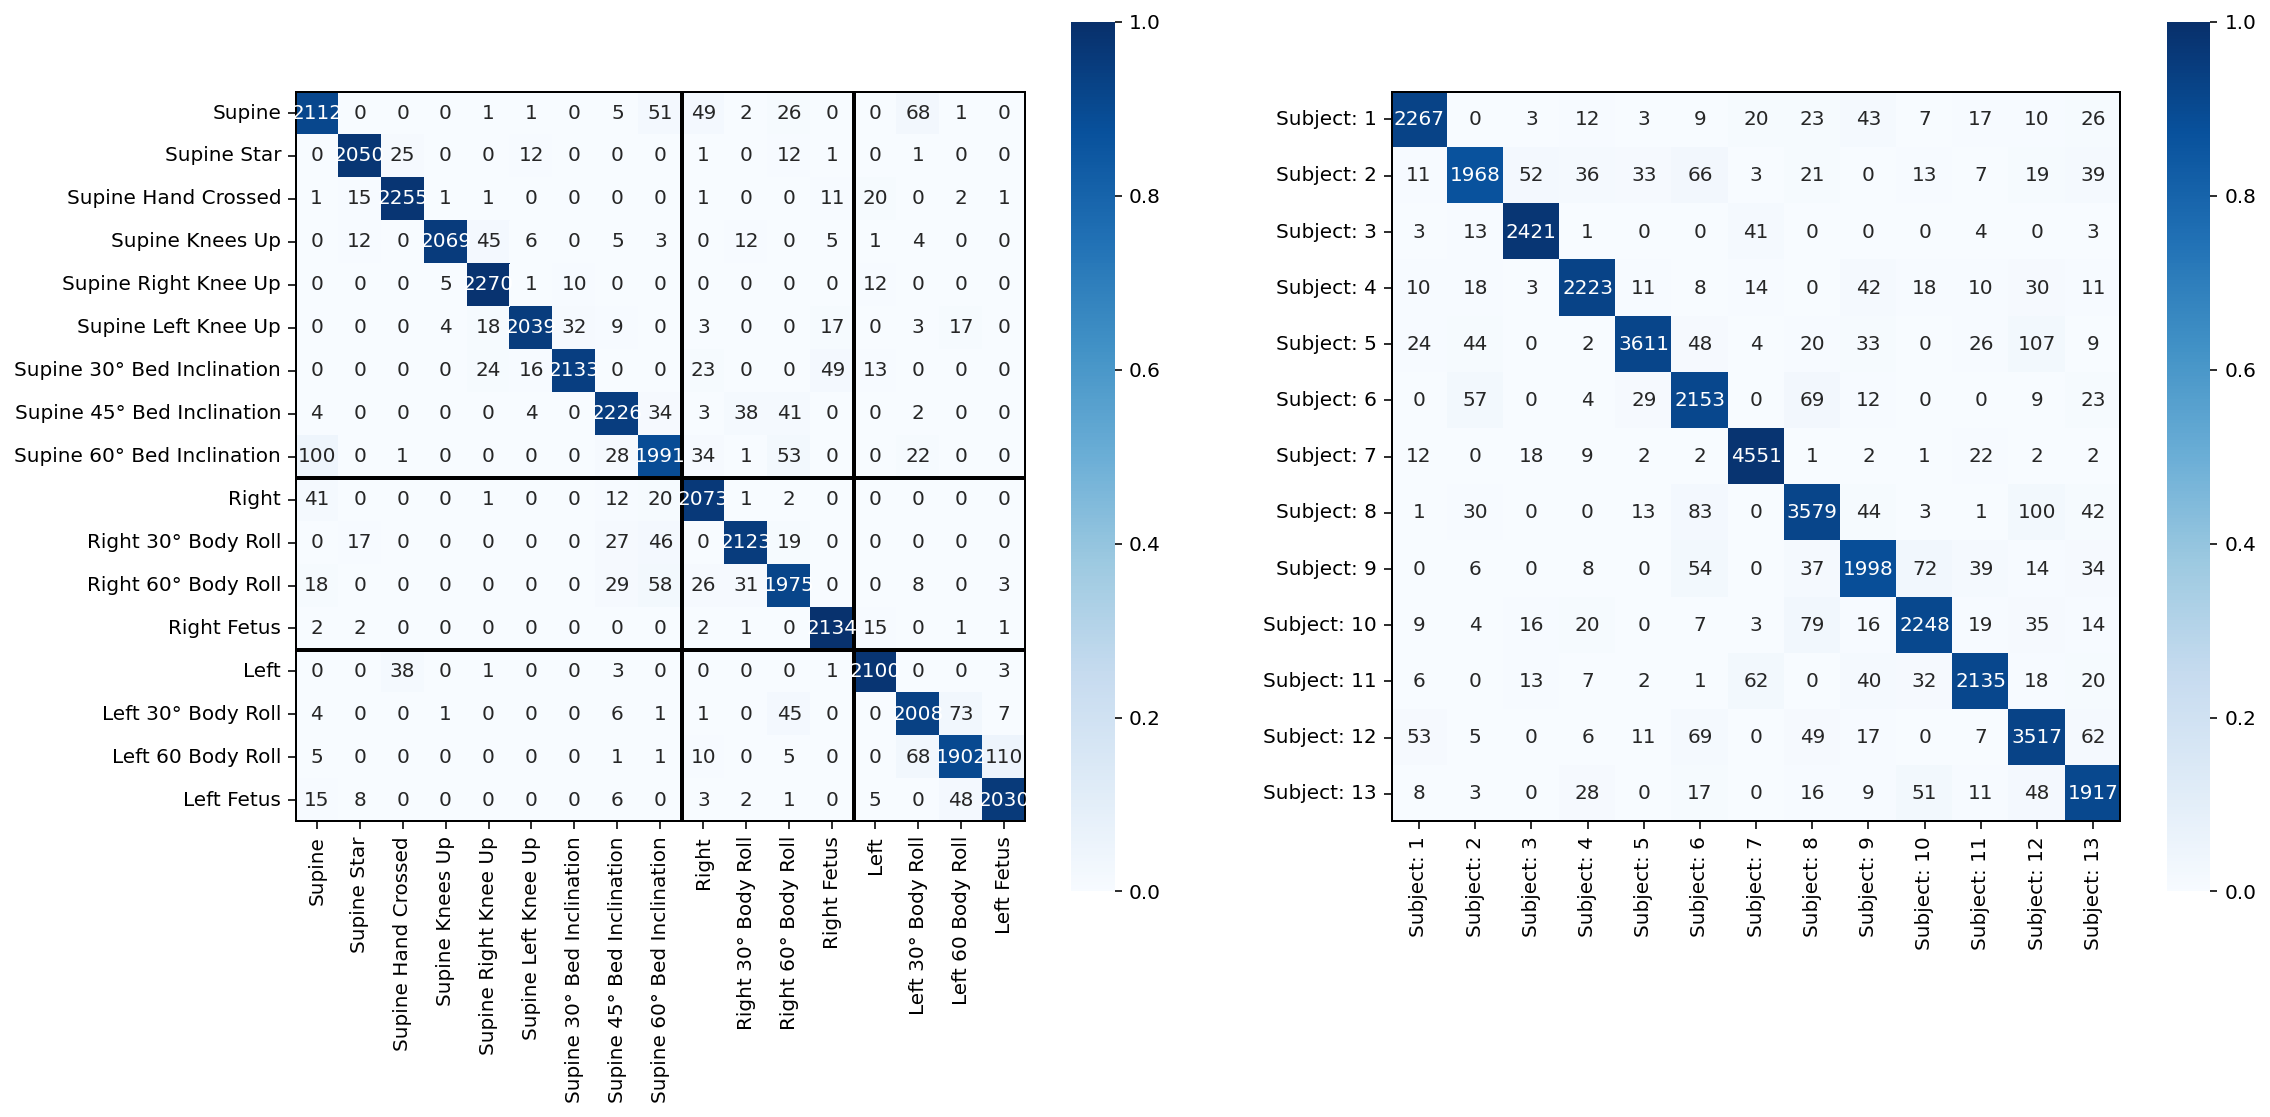

In [ ]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

### CNN

In [ ]:
%%time
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

print('-----------------')
print('KFold Initialization.')
print('-----------------')

#cv = KFold(n_splits=fold, shuffle=True, random_state=123)
cv = RepeatedKFold(n_splits=fold, n_repeats=2,random_state=36851234)
for train, test in cv.split(x):

    X_train, X_test = tf.gather(x_aug, indices=train), tf.gather(x, indices=test) #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]
    y_train_sub, y_test_sub = y_sub[train], y_sub[test]
    
    if k==1: 
        summary=True
    else: summary=False
        
    model, pos_layer, sub_layer = cnn_model(n_conv=2, n_channels=16, n_dense=2, n_neurons=64, n_pos=17, summary=summary)

    model = train_model(model, X_train, y_train_sub, y_train_pos,
                        plot=False, n_epochs=30, verbose=0, lambda_=0.5, name_model='cnn.h5')

    acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(X_test,y_test_sub, y_test_pos, 
                                                          plot=False, classification_rep=False)

    matrix_sub_ += matrix_sub
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    kfold_acc_sub.append(acc_sub)

    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    
    tf.keras.backend.clear_session()
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')
print('Average Kfold Subject Accuracy:',round(np.mean(kfold_acc_sub),2),'%')
print('Standard deviation Subject:',round(statistics.pstdev(kfold_acc_sub),2),'%')

-----------------
KFold Initialization.
-----------------
Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 layer (Layer)                  (None, 64, 32, 1)    0           ['Input[0][0]']                  
                                                                                                  
 Conv-1a (Conv2D)               (None, 62, 30, 16)   160         ['layer[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 62, 30, 16)  64          ['Conv-1a[0][0]']                
 alization)                           

# LOSO Validation Scheme

  - LOSO = Leave on Subject out, basically we trained on the other 12 subjects and tested on the last one. This has been reiterated for all the subjects.

In [ ]:
groups = frames["subject"]
logo = LeaveOneGroupOut()

### CNN

In [ ]:
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

k=0
for train_index, test_index in logo.split(x, y_pos, groups):
  
  model, pos_layer, sub_layer = cnn_model(n_conv=2, n_channels=16, n_dense=2, n_neurons=64, n_pos=17,summary=False)
    
  model = train_model(model, x_aug[train_index], y_sub[train_index], y_pos[train_index], plot=False,
                      n_epochs=50, lambda_=0.5, verbose=0,batch_size=100)
    
  acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(x[test_index], y_sub[test_index], y_pos[test_index], 
                                                          plot=False, classification_rep=False)
  
  matrix_sub_ += 0
  matrix_pos_ += matrix_pos

  kfold_acc_pos.append(acc_pos)
  kfold_acc_sub.append(acc_sub)
  
  print('{}- finished!'.format(k))
  print('-----------------')
    
  tf.keras.backend.clear_session()
  k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')

In [ ]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

### CNN+RNN

In [ ]:
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

k=0
for train_index, test_index in logo.split(x, y_pos, groups):
  
  model, pos_layer, sub_layer = cnn_rnn_model(n_conv=2, n_channels=16, n_dense=3, n_neurons=256, n_pos=17, summary=False)
    
  model = train_model(model, x_aug[train_index], y_sub[train_index], y_pos[train_index], plot=False,
                      n_epochs=50, lambda_=0.5, verbose=0, batch_size=100)
    
  acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(x[test_index], y_sub[test_index], y_pos[test_index], 
                                                          plot=False, classification_rep=False)
  
  matrix_sub_ += 0
  matrix_pos_ += matrix_pos

  kfold_acc_pos.append(acc_pos)
  kfold_acc_sub.append(acc_sub)
  
  print('{}- finished!'.format(k))
  print('-----------------')
    
  tf.keras.backend.clear_session()
  k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')

In [ ]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

### CNN+LSTM

In [ ]:
kfold_acc_pos = []
kfold_acc_sub = []
fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

k=0
for train_index, test_index in logo.split(x, y_pos, groups):
  
  model, pos_layer, sub_layer = cnn_lstm_model(n_conv=2, n_channels=32, n_dense=2, n_neurons=64, n_pos=17, summary=False)
    
  model = train_model(model, x_aug[train_index], y_sub[train_index], y_pos[train_index], plot=False,
                      n_epochs=50, lambda_=0.5, verbose=0, batch_size=100)
    
  acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(x[test_index], y_sub[test_index], y_pos[test_index], 
                                                          plot=False, classification_rep=False)
  
  matrix_sub_ += 0
  matrix_pos_ += matrix_pos

  kfold_acc_pos.append(acc_pos)
  kfold_acc_sub.append(acc_sub)
  
  print('{}- finished!'.format(k))
  print('-----------------')
    
  tf.keras.backend.clear_session()
  k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')

In [ ]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

### Our Model LOSO Validation

The same cell has been used for the KFold validation with some few modifications.
Of course for the LOSO validation the subject confusion matrix is useless

In [10]:
kfold_acc_pos = []
kfold_acc_sub = []
k=1

groups = frames["subject"]
logo = LeaveOneGroupOut()

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

k=1
for train_index, test_index in logo.split(x, y_pos, groups):
  
  model = model2(n_inception=32, n_dense=64, summary=False)    

  model = train_model(model, x_aug[train_index], y_sub[train_index], y_pos[train_index], plot=False,
                      n_epochs=10, lambda_=0.2, verbose=1, batch_size=100)
    
  acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(x[test_index], y_sub[test_index], y_pos[test_index], 
                                                          plot=False, classification_rep=False)
  
  matrix_sub_ += 0
  matrix_pos_ += matrix_pos

  kfold_acc_pos.append(acc_pos)
  kfold_acc_sub.append(acc_sub)
  
  print('{}- finished!'.format(k))
  print('-----------------')
    
  tf.keras.backend.clear_session()
  k+=1

print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Standard deviation Position:',round(statistics.pstdev(kfold_acc_pos),2),'%')

Epoch 1/10
175/175 [==============================] - 47s 169ms/step - loss: 1.1063 - Output-Subject_loss: 2.2676 - Softmax-Output_loss: 0.8160 - Output-Subject_accuracy: 0.2336 - Softmax-Output_accuracy: 0.7609 - lr: 0.0010
Epoch 2/10
175/175 [==============================] - 27s 155ms/step - loss: 0.3796 - Output-Subject_loss: 1.1679 - Softmax-Output_loss: 0.1825 - Output-Subject_accuracy: 0.6252 - Softmax-Output_accuracy: 0.9441 - lr: 0.0010
Epoch 3/10
175/175 [==============================] - 28s 159ms/step - loss: 0.1986 - Output-Subject_loss: 0.5826 - Softmax-Output_loss: 0.1026 - Output-Subject_accuracy: 0.8337 - Softmax-Output_accuracy: 0.9684 - lr: 0.0010
Epoch 4/10
175/175 [==============================] - 28s 163ms/step - loss: 0.1165 - Output-Subject_loss: 0.3307 - Softmax-Output_loss: 0.0629 - Output-Subject_accuracy: 0.9076 - Softmax-Output_accuracy: 0.9814 - lr: 0.0010
Epoch 5/10
175/175 [==============================] - 28s 161ms/step - loss: 0.0901 - Output-Subject

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


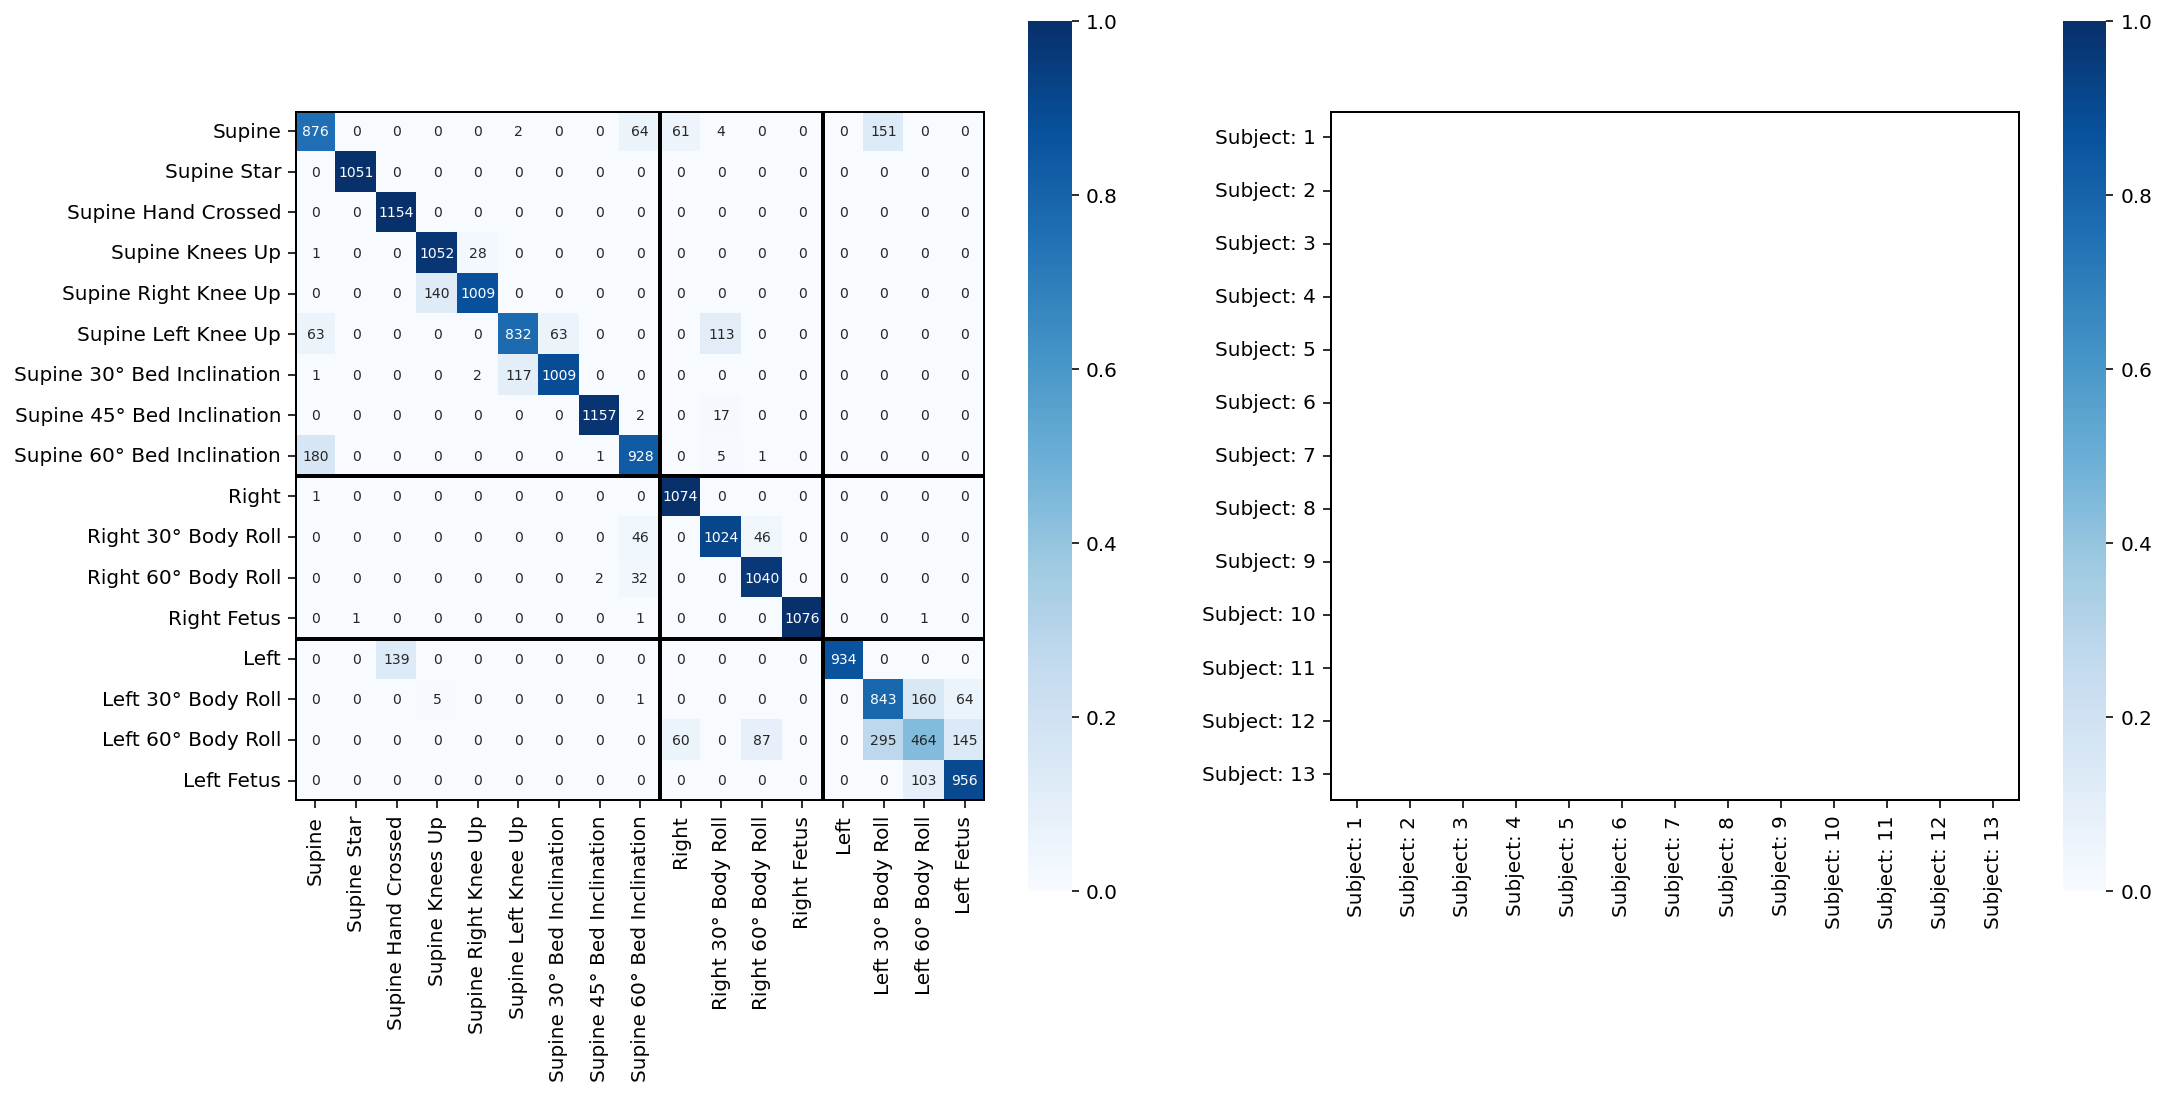

In [18]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60° Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(17,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True, annot_kws={"fontsize":7})
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True, annot_kws={"fontsize":4})
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()